# Proyecto 1 Minería de Datos.
Importacion de librerias. 

In [1]:
import pyreadstat
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ks_2samp, anderson
import matplotlib.pyplot as plt
import seaborn as sns

Exportación de los datos de bases de datos obtenidas de las [Estadísticas Hospitalarias](https://www.ine.gob.gt/estadisticas-hospitalarias/) del Instituto Nacional de Estadística de Guatemala (INE).

Cada archivo tiene los datos pertenecientes a un año en específico. Se leen los datos y se almacenan en una lista. 


In [2]:
dfs = []

for i in range(2012, 2023):
    df, metadata = pyreadstat.read_sav(f'./data/{i}.sav', encoding="latin1")
    dfs.append(df)

Se usa el primer dataframe como el dataframe  principal y los demas se fusionan con este. Pero antes se organiza la columns para reestructurar la columna "GRUPETNICO" para adaptarla a su contraparte "PPERTENENCIA" que es utilizada en dataframes modernos. 

In [3]:
df = dfs[-1]
for year in dfs[:-1]:
    if 'GRUPETNICO' in year.columns:
        year.rename(columns={'GRUPETNICO': 'PPERTENENCIA'}, inplace = True)
        year['PPERTENENCIA'] = year['PPERTENENCIA'].replace({1: 6, 2: 4})
    df = df._append(year)

df

,AÑO,MES,DIASESTANCIA,SEXO,PPERTENENCIA,EDAD,PERIODOEDA,DEPTORESIDEN,MUNIRESIDEN,CAUFIN,CONDIEGRES,TRATARECIB
0,2022.0,7.0,1.0,2.0,9.0,1.0,2.0,13.0,1301,A010,1.0,1.0
1,2022.0,5.0,1.0,2.0,9.0,1.0,3.0,1.0,0108,A010,1.0,1.0
2,2022.0,4.0,1.0,2.0,9.0,1.0,3.0,10.0,1010,A010,1.0,1.0
3,2022.0,1.0,1.0,1.0,9.0,1.0,2.0,13.0,1303,A010,1.0,1.0
4,2022.0,8.0,1.0,2.0,4.0,3.0,3.0,18.0,1804,A010,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
228466,2021.0,5.0,9999.0,1.0,9.0,999.0,9.0,99.0,9999,Z380,1.0,1.0
228467,2021.0,5.0,9999.0,1.0,9.0,999.0,9.0,99.0,9999,Z380,1.0,1.0
228468,2021.0,5.0,9999.0,1.0,9.0,999.0,9.0,99.0,9999,Z380,1.0,1.0
228469,2021.0,6.0,3.0,1.0,1.0,3.0,1.0,99.0,9999,Z380,1.0,1.0


In [4]:
dfCopy = df.copy()

Se verifica la cantidad de elementos nulos en el dataframe.

In [5]:
# Contar los valores NA por columna
na_count = df.isna().sum()

# Filtrar columnas con valores NA
columns_with_na = na_count[na_count > 0]

print("Cantidad de valores NA por columna:")
print(na_count)

print("\nColumnas con valores NA:")
print(columns_with_na)

Cantidad de valores NA por columna:
AÑO             0
MES             0
DIASESTANCIA    0
SEXO            0
PPERTENENCIA    0
EDAD            0
PERIODOEDA      0
DEPTORESIDEN    0
MUNIRESIDEN     0
CAUFIN          0
CONDIEGRES      0
TRATARECIB      0
dtype: int64

Columnas con valores NA:
Series([], dtype: int64)


Se observan los tipos de cada una de las variables del dataframe. 

In [6]:
infoSumary = df.info()
infoSumary

<class 'pandas.core.frame.DataFrame'>
Index: 2499795 entries, 0 to 228470
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   AÑO           float64
 1   MES           float64
 2   DIASESTANCIA  float64
 3   SEXO          float64
 4   PPERTENENCIA  float64
 5   EDAD          float64
 6   PERIODOEDA    float64
 7   DEPTORESIDEN  float64
 8   MUNIRESIDEN   object 
 9   CAUFIN        object 
 10  CONDIEGRES    float64
 11  TRATARECIB    float64
dtypes: float64(10), object(2)
memory usage: 247.9+ MB


Descripción de los datos de las variables en el dataframe. Gracias a esto se identificó que de forma erronea existen registros de personas con 999.0 años. 

In [7]:
df.describe()

,AÑO,MES,DIASESTANCIA,SEXO,PPERTENENCIA,EDAD,PERIODOEDA,DEPTORESIDEN,CONDIEGRES,TRATARECIB
count,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06,2.499795e+06
mean,2.017180e+03,6.432386e+00,3.147715e+02,1.631465e+00,5.756676e+00,4.346715e+01,2.846542e+00,6.830349e+00,1.009392e+00,1.477632e+00
std,3.026397e+00,3.407258e+00,1.740414e+03,6.361045e-01,2.573496e+00,9.048782e+01,8.158357e-01,9.825729e+00,2.121092e-01,7.243745e-01
min,2.012000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.015000e+03,3.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.700000e+01,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,2.017000e+03,6.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,3.300000e+01,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,2.020000e+03,9.000000e+00,2.000000e+00,2.000000e+00,9.000000e+00,5.500000e+01,3.000000e+00,1.200000e+01,1.000000e+00,2.000000e+00
max,2.022000e+03,1.200000e+01,9.999000e+03,9.000000e+00,9.000000e+00,9.990000e+02,9.000000e+00,9.900000e+01,9.000000e+00,9.000000e+00


En base a esto, se decidió eliminar los valores con la edad erronea

In [8]:
df = df.loc[df['EDAD'] <= 120.0]

Se mide la normalidad de las variables númericas que posee el dataframe (DIASESTANCIA y EDAD) mediante el uso de anderson y un histograma. En base a estó se rechazó la hipotesis nula de la normalidad para ambas variables. 

Columna DIASESTANCIA: Estadística=921449.2652
La columna DIASESTANCIA no sigue una distribución normal al 15.0% de confianza.


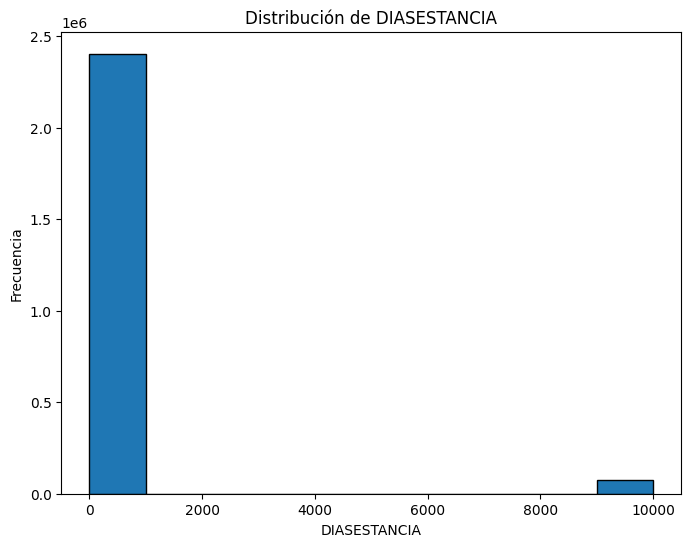

Columna EDAD: Estadística=24592.1135
La columna EDAD no sigue una distribución normal al 15.0% de confianza.


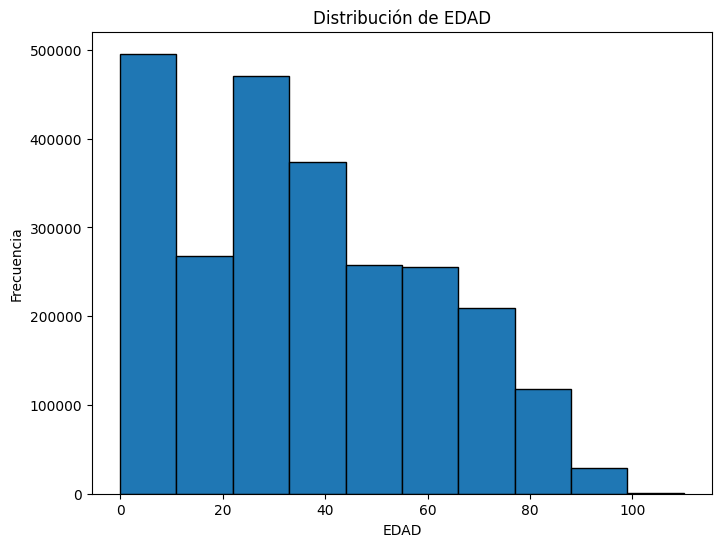

In [9]:
for column in ['DIASESTANCIA', 'EDAD']:
    result = anderson(df[column])
    statistic = result.statistic
    critical_values = result.critical_values
    significance_level = result.significance_level

    print(f'Columna {column}: Estadística={statistic:.4f}')

    # Comparar la estadística con los valores críticos
    for i, alpha in enumerate([15.0, 10.0, 5.0, 2.5, 1.0]):
        if statistic > critical_values[i]:
            print(f'\033[91mLa columna {column} no sigue una distribución normal al {alpha}% de confianza.\033[0m')
            break
    else:
        print(f'\033[92mLa columna {column} sigue una distribución normal al 1% de confianza.\033[0m')


    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=10, edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()


Ahora con las variables categoricas. Se realizan tablas de frecuencia para cada una, se evalua la moda. Y para las que tengan menos de 11 categorías se realizó un gráfico de barras en base a las frecuencias. 

Tabla de frecuencia para la variable 'AÑO':
        Frecuencia  Porcentaje
AÑO                           
2019.0      285712   11.524600
2020.0      260655   10.513890
2016.0      249061   10.046230
2018.0      237943    9.597769
2015.0      229140    9.242688
2021.0      227632    9.181860
2017.0      222555    8.977072
2014.0      205157    8.275299
2022.0      193752    7.815262
2013.0      185435    7.479784
2012.0      182107    7.345545
 La moda es 2019.0 

Gráfico de barras para la variable 'AÑO':


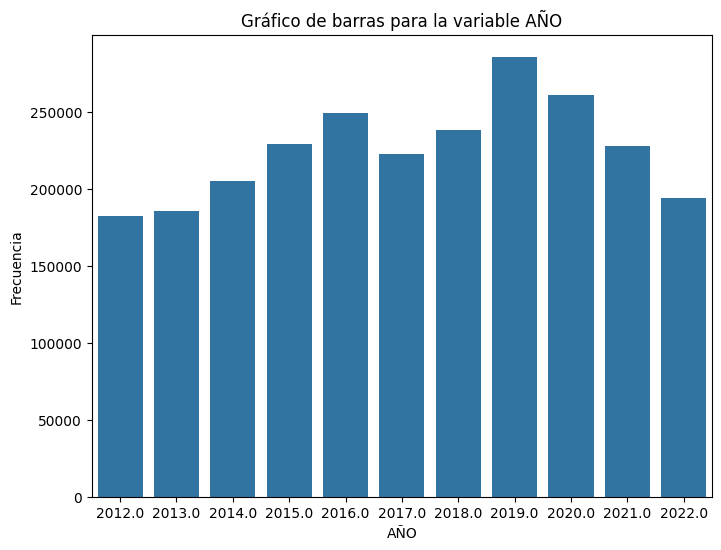


Tabla de frecuencia para la variable 'MES':
      Frecuencia  Porcentaje
MES                         
5.0       217412    8.769622
3.0       217048    8.754940
7.0       216136    8.718153
8.0       215411    8.688909
9.0       210367    8.485452
10.0      209176    8.437411
1.0       207199    8.357666
4.0       203195    8.196159
6.0       201684    8.135211
2.0       201683    8.135171
11.0      194132    7.830590
12.0      185706    7.490716
 La moda es 5.0 

 La variable tiene más de 11 categorías, no se generará un gráfico de barras. 

Tabla de frecuencia para la variable 'SEXO':
      Frecuencia  Porcentaje
SEXO                        
2.0      1504244   60.675821
1.0       967518   39.026214
9.0         7387    0.297965
 La moda es 2.0 

Gráfico de barras para la variable 'SEXO':


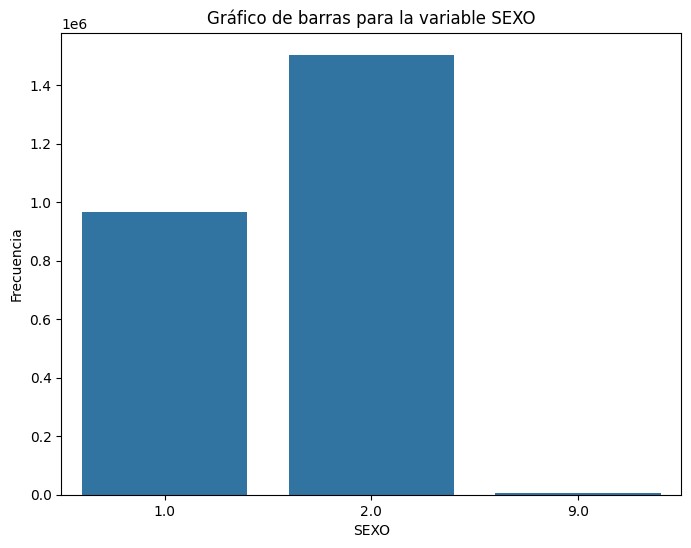


Tabla de frecuencia para la variable 'PPERTENENCIA':
              Frecuencia  Porcentaje
PPERTENENCIA                        
4.0              1285692   51.860215
9.0               883279   35.628314
6.0               169316    6.829602
1.0               138578    5.589741
5.0                 1615    0.065143
2.0                  571    0.023032
3.0                   98    0.003953
 La moda es 4.0 

Gráfico de barras para la variable 'PPERTENENCIA':


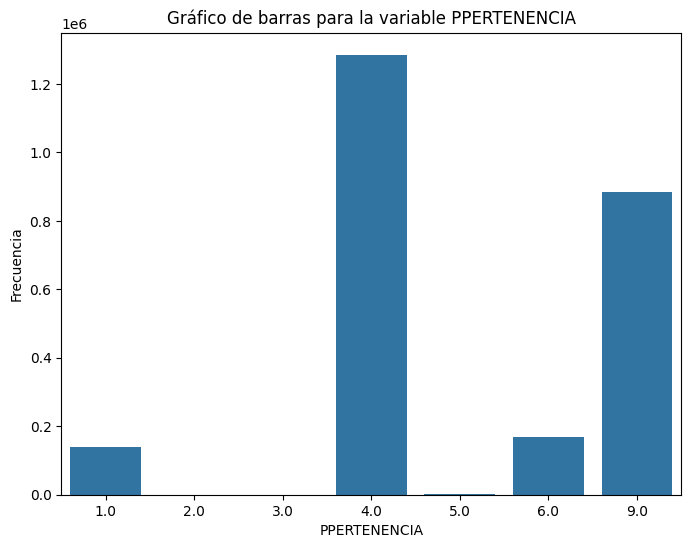


Tabla de frecuencia para la variable 'PERIODOEDA':
            Frecuencia  Porcentaje
PERIODOEDA                        
3.0            2207638   89.048218
1.0             235978    9.518508
2.0              35533    1.433274
 La moda es 3.0 

Gráfico de barras para la variable 'PERIODOEDA':


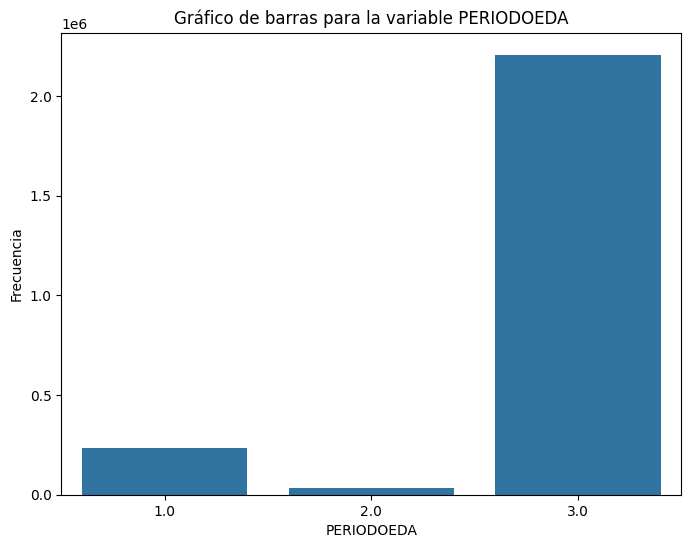


Tabla de frecuencia para la variable 'DEPTORESIDEN':
              Frecuencia  Porcentaje
DEPTORESIDEN                        
1.0              1306626   52.704618
9.0               114989    4.638245
13.0              108791    4.388240
5.0                88329    3.562876
16.0               85206    3.436905
12.0               78100    3.150275
22.0               59428    2.397113
11.0               59270    2.390740
10.0               58256    2.349839
4.0                50219    2.025655
18.0               47999    1.936108
20.0               46411    1.872054
14.0               45976    1.854507
19.0               44991    1.814776
3.0                40285    1.624953
17.0               39002    1.573201
21.0               34555    1.393825
15.0               33772    1.362242
6.0                31286    1.261965
8.0                30712    1.238812
2.0                24228    0.977271
7.0                23703    0.956094
99.0               14046    0.566565
23.0               12

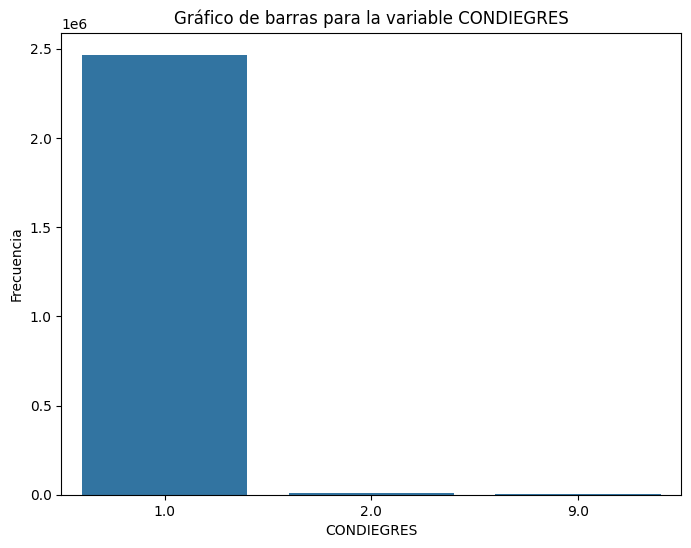


Tabla de frecuencia para la variable 'TRATARECIB':
            Frecuencia  Porcentaje
TRATARECIB                        
1.0            1611360   64.996497
2.0             557323   22.480416
3.0             309347   12.477951
9.0               1119    0.045136
 La moda es 1.0 

Gráfico de barras para la variable 'TRATARECIB':


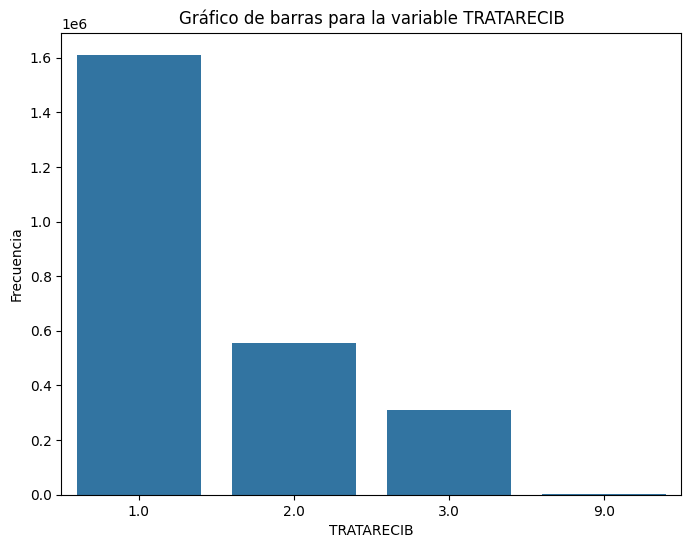

In [10]:
dfCategoricas = df.drop(columns=["DIASESTANCIA", "EDAD"])

for column in dfCategoricas.columns:
    freq_table = dfCategoricas[column].value_counts()
    percentage_table = dfCategoricas[column].value_counts(normalize=True) * 100
    print(f"Tabla de frecuencia para la variable '{column}':")
    print(pd.concat([freq_table, percentage_table], axis=1, keys=['Frecuencia', 'Porcentaje']))
    print('\33[92m','La moda es', dfCategoricas[column].mode().values[0], '\33[0m')
    print()

    if dfCategoricas[column].nunique() > 11:
        print('\33[91m', 'La variable tiene más de 11 categorías, no se generará un gráfico de barras.', '\33[0m')
        print()
        continue
    print(f"Gráfico de barras para la variable '{column}':")
    plt.figure(figsize=(8, 6))
    sns.countplot(data=dfCategoricas, x=column)
    plt.title(f'Gráfico de barras para la variable {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()
    print()
    


In [11]:
df2 = df.copy()
def change(variable):
    dictValue = {'NA': 0}
    count = 1

    def changeToVariable(x):
        nonlocal count  # Para indicar que count es una variable no local
        if x in dictValue:
            return dictValue[x]
        else:
            dictValue[x] = count
            count += 1
            return dictValue[x]
        
    if not pd.api.types.is_numeric_dtype(df2[variable]):
        df2[variable] = df2[variable].apply(changeToVariable)
    
        print(f'Para la variable {variable} los valores ahora son: ')
        for key, value in dictValue.items():
            print(key, ":", value)
    else:
        print(f"La columna {variable} es numerica")

for variable in df2.columns:
    change(variable=variable)

La columna AÑO es numerica
La columna MES es numerica
La columna DIASESTANCIA es numerica
La columna SEXO es numerica
La columna PPERTENENCIA es numerica
La columna EDAD es numerica
La columna PERIODOEDA es numerica
La columna DEPTORESIDEN es numerica
Para la variable MUNIRESIDEN los valores ahora son: 
NA : 0
1301 : 1
0108 : 2
1010 : 3
1303 : 4
1804 : 5
1603 : 6
1230 : 7
0404 : 8
1108 : 9
1606 : 10
0409 : 11
1901 : 12
1312 : 13
1401 : 14
1609 : 15
2203 : 16
1302 : 17
0511 : 18
1327 : 19
0713 : 20
1315 : 21
1305 : 22
1003 : 23
0401 : 24
0103 : 25
0101 : 26
1406 : 27
1801 : 28
0501 : 29
2001 : 30
1419 : 31
1308 : 32
1226 : 33
0115 : 34
1320 : 35
1008 : 36
2211 : 37
1412 : 38
1409 : 39
0412 : 40
1307 : 41
1324 : 42
1105 : 43
1001 : 44
1413 : 45
1310 : 46
1304 : 47
0301 : 48
1415 : 49
0924 : 50
1322 : 51
1332 : 52
0801 : 53
1501 : 54
1319 : 55
1414 : 56
1316 : 57
2300 : 58
1317 : 59
1311 : 60
2205 : 61
1101 : 62
1602 : 63
1601 : 64
1610 : 65
1508 : 66
0502 : 67
1004 : 68
0614 : 69
1611 : 

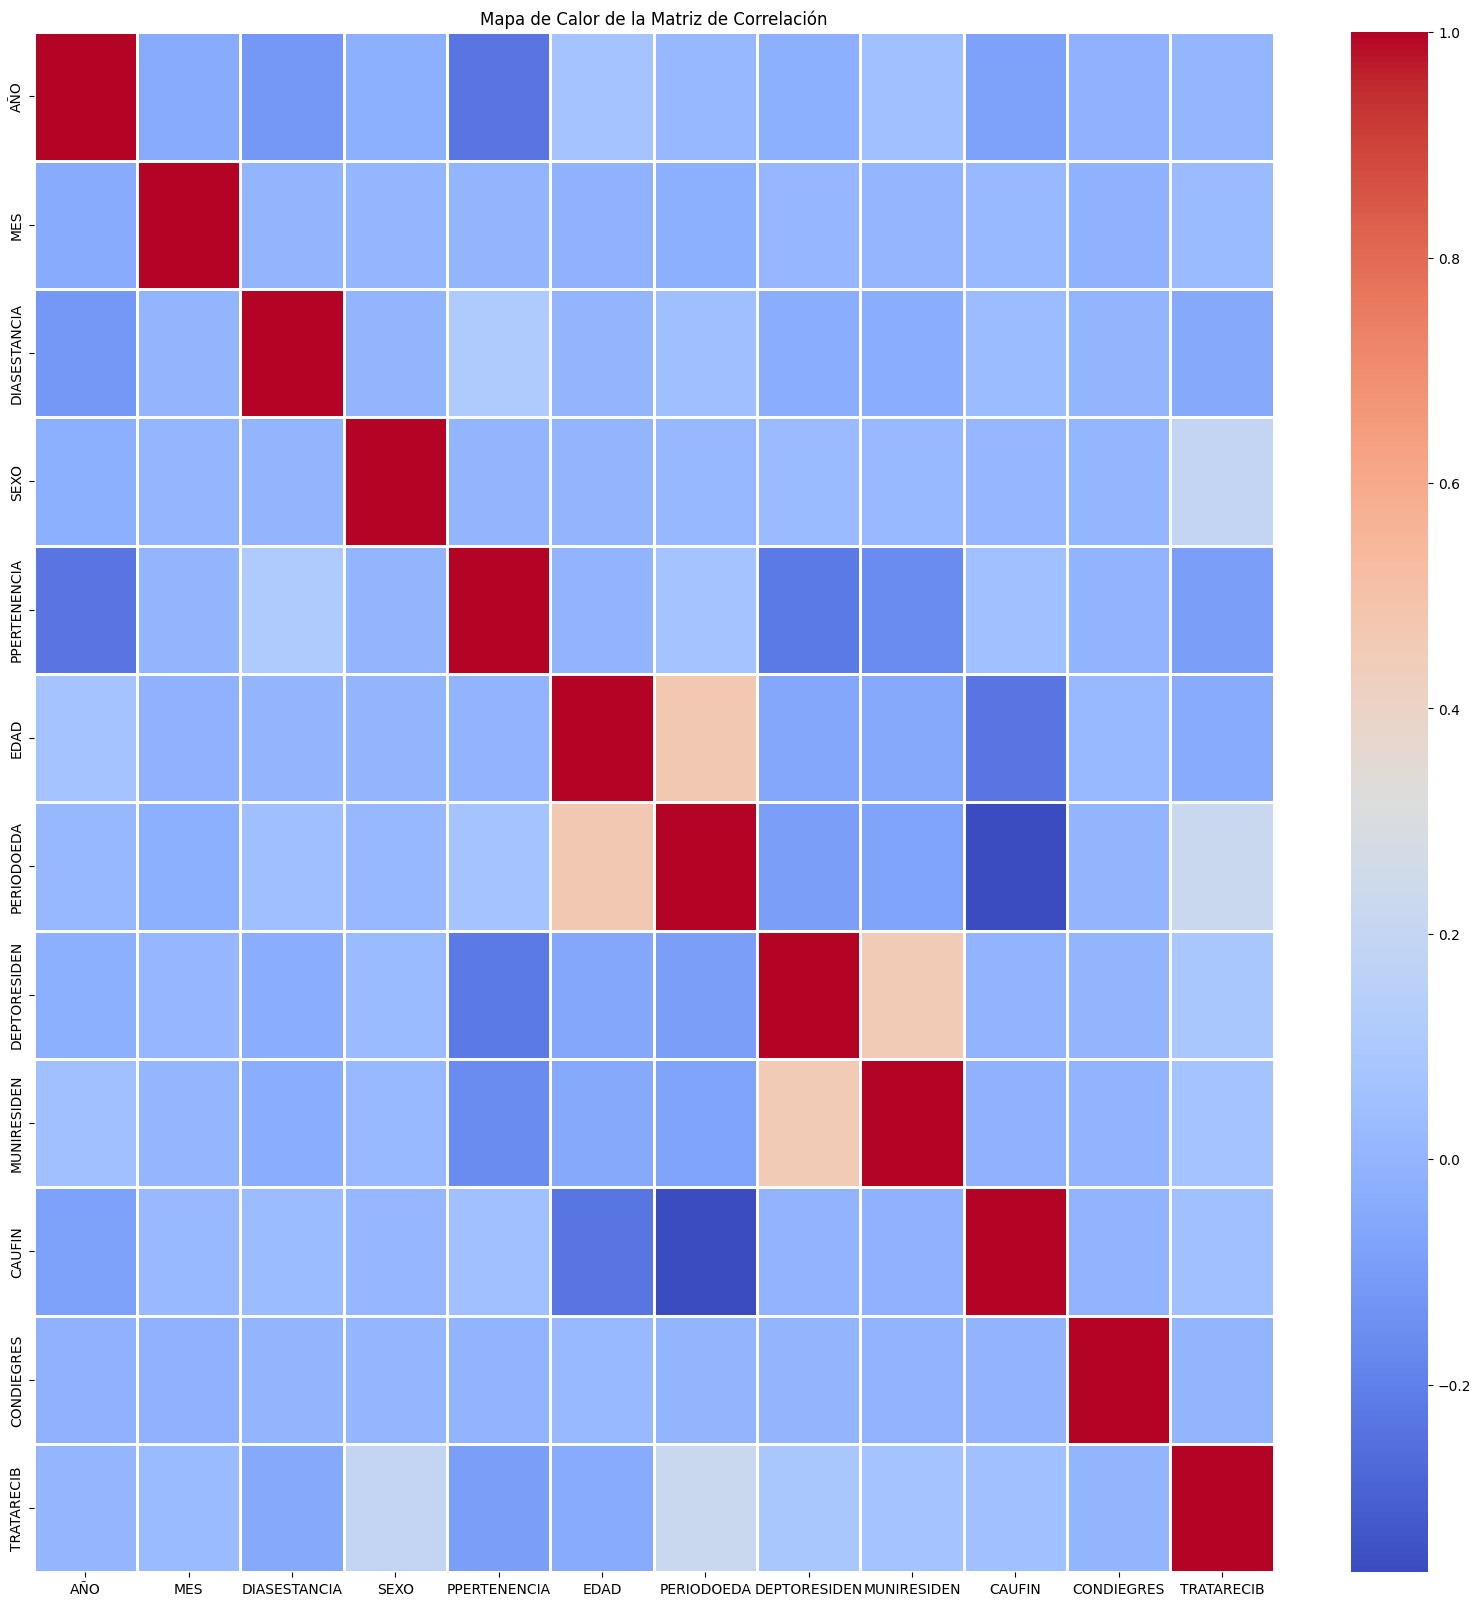

In [12]:
df_numeric = df2

# Mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(20, 20))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=1)

plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()